In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os

from astropy import units as u
from astropy.constants import G
from astropy.io import ascii, fits
from astropy.table import Table
from astropy.timeseries import LombScargle
import astropy.time
import dateutil.parser

from matplotlib import gridspec
import scipy.optimize as sciop
import json
from scipy.stats import mode

from lightkurve import search_targetpixelfile

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

from scipy.stats import binned_statistic

import corner

%matplotlib inline

In [122]:
jan1_1996 = '1996-01-01T00:00:00.000Z'
jan1_1996 = astropy.time.Time(jan1_1996).jd
print(jan1_1996)

2450083.5


In [123]:
dayspermonth = [31,28,31,30,31,30,31,31,30,31,30,31,0]
months = [r'Jan',r'Feb',r'Mar',r'Apr',r'May',r'June',r'July',r'Aug',r'Sept',r'Oct',r'Nov',r'Dec','']
# all years divisible by 4 during SOHO are leap years, including 2000

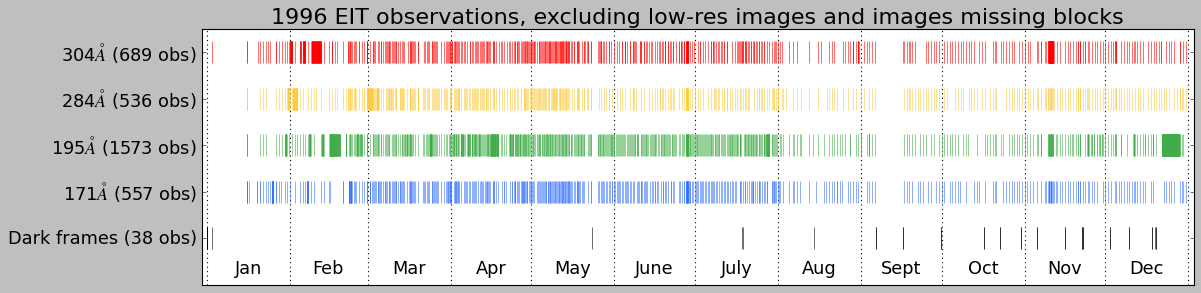

In [130]:
#for year in range(1996, 2010):
for year in [1996]:
    jan1_thisyear = '{0}-01-01T00:00:00.000Z'.format(year)
    jan1_thisyear = astropy.time.Time(jan1_thisyear).jd
    
    obsTimes_171 = []
    obsTimes_195 = []
    obsTimes_284 = []
    obsTimes_304 = []
    obsTimes_dark = []
    for m in range(1,13):
        month = str(m).zfill(2)
        days = sorted([int(f.path[-2:]) for f in os.scandir("./EIT/{0}/{1}/".format(year,month)) if f.is_dir()])
        #print(month)
        for d in days:
            #print(d)
            day = str(d).zfill(2)
            fitsFiles = os.scandir("./EIT/{0}/{1}/{2}/".format(year,month,day))
            for f in fitsFiles:
                #print(f.path)
                hdul = fits.open(f.path)
                header = hdul[0].header
                data = hdul[0].data
    
                if "DRK" in f.name:
                    #separate out what I assume are mis-labeled stray light images
                    if np.median(data) < 1000.:
                        #print(header['DATE-BEG'])
                        obsTimes_dark.append(header['DATE-BEG'])
                elif "CAL" in f.name:
                    #print(header['SCI_OBJ'])
                    pass
                else:
                    wavelength = header['WAVELNTH']
    
                    #exclude lower-resolution or partial images and images with missing data blocks
                    if np.shape(data) == (1024,1024) and header['MSBLOCKS'] == 0:
                        if wavelength == 171:
                            obsTimes_171.append(header['DATE-BEG'])
                        if wavelength == 195:
                            obsTimes_195.append(header['DATE-BEG'])
                        if wavelength == 284:
                            obsTimes_284.append(header['DATE-BEG'])
                        if wavelength == 304:
                            obsTimes_304.append(header['DATE-BEG'])
    
    tDark = astropy.time.Time(obsTimes_dark, format='isot', scale='utc').jd
    t171 = astropy.time.Time(obsTimes_171, format='isot', scale='utc').jd
    t195 = astropy.time.Time(obsTimes_195, format='isot', scale='utc').jd
    t284 = astropy.time.Time(obsTimes_284, format='isot', scale='utc').jd
    t304 = astropy.time.Time(obsTimes_304, format='isot', scale='utc').jd

    fig, ax = plt.subplots(1,1,figsize=(16,4))

    runningdaycount = 0
    for i, d in enumerate(dayspermonth):
        ax.axvline(runningdaycount,color='k',ls=':')    
        ax.text(runningdaycount + d/2, -0.75, months[i],horizontalalignment='center',fontsize=16)
        runningdaycount = runningdaycount+d
        # leap years
        if year%4 == 0 and i==1:
            runningdaycount = runningdaycount + 1
    
    ax.plot(tDark-jan1_thisyear, np.zeros_like(tDark), ls='None',marker='|',ms=20,mec='k')
    ax.plot(t171-jan1_thisyear, np.ones_like(t171), ls='None',   marker='|',ms=20,mec='#3772ff')
    ax.plot(t195-jan1_thisyear, 2*np.ones_like(t195), ls='None', marker='|',ms=20,mec='#41ad49')
    ax.plot(t284-jan1_thisyear, 3*np.ones_like(t284), ls='None', marker='|',ms=20,mec='#fdca40')
    ax.plot(t304-jan1_thisyear, 4*np.ones_like(t304), ls='None', marker='|',ms=20,mec='r')
    #ax.set_xlabel('time', fontsize=16) #("BJD-2450083.5 [days since 01/01/{0} 00:00 UTC]".format(year),fontsize=16)
    ax.set_yticks([0,1,2,3,4])
    ax.set_yticklabels([r"Dark frames ({0} obs)".format(len(tDark)), 
                        r"171$\AA$ ({0} obs)".format(len(t171)),
                        r"195$\AA$ ({0} obs)".format(len(t195)),
                        r"284$\AA$ ({0} obs)".format(len(t284)),
                        r"304$\AA$ ({0} obs)".format(len(t304))],fontsize=16)
    ax.set_xticks([])
    ax.set_ylim(-1,4.5) 
    ax.set_xlim(-2,runningdaycount+2)
    
    ax.set_title(r'{0} EIT observations, excluding low-res images and images missing blocks'.format(year),fontsize=20)
    #plt.show()
    plt.savefig("./EITschedule_{0}.pdf".format(year), bbox_inches="tight")
